In [1]:
import torch 
import torch.nn as nn 
from torch.optim import adam 
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader , Dataset 
from torchvision import models ## it contain all pretrained model as u no lenet,alexnet...... 
from sklearn.preprocessing import LabelEncoder  
import matplotlib.pyplot as plt 
from PIL import Image 
import pandas as pd 
import numpy as np 
import os 




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [3]:
data_dir= "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" 

train_dir = os.path.join(data_dir , 'train') 
valid_dir = os.path.join(data_dir , "valid") 

labels =[] 
image_path = [] 
i = 0 
for label in os.listdir(train_dir):  
    for img_path in os.listdir(os.path.join(train_dir , label)):
        labels.append(label) 
        image_path.append(os.path.join(train_dir , label,img_path))

             
val_label = [] 
val_img_path = []
for label in os.listdir(valid_dir):  
    for img_path in os.listdir(os.path.join(valid_dir , label)) : 
        val_label.append(label) 
        val_img_path.append(os.path.join(valid_dir,label , img_path))

In [4]:
## coverting it to dataset 
train_datasets = pd.DataFrame({"image_path":image_path , "labels":labels}) 
val_datasets = pd.DataFrame({"image_path":val_img_path , "labels":val_label}) 
train_datasets['image_path'].values[0]

'/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight/781e93a9-2059-42de-8075-658033a6abf7___RS_Late.B 6075.JPG'

In [5]:
train_datasets['labels'].nunique()

38

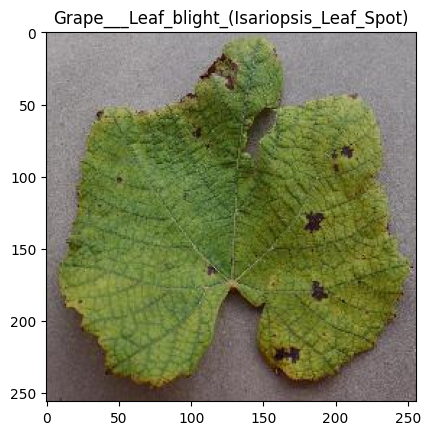

In [6]:
import random 
num = random.randint(0 , len(image_path)) 
img = image_path[num] 
label = labels[num] 
im =plt.imread(img) 
plt.imshow(im) 
plt.title(label);

In [7]:
train_datasets.sample(5)

,image_path,labels
22438,/kaggle/input/new-plant-diseases-dataset/New P...,Peach___healthy
25834,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Tomato_Yellow_Leaf_Curl_Virus
45525,/kaggle/input/new-plant-diseases-dataset/New P...,Potato___Late_blight
61031,/kaggle/input/new-plant-diseases-dataset/New P...,Grape___Esca_(Black_Measles)
21536,/kaggle/input/new-plant-diseases-dataset/New P...,Strawberry___Leaf_scorch


In [8]:
## convertig the labels into the integers 
label_encoder = LabelEncoder() 

train_datasets['labels'] = label_encoder.fit_transform(train_datasets['labels']) 
val_datasets['labels'] = label_encoder.fit_transform(val_datasets['labels'])

In [47]:
label_classes = dict(zip( label_encoder.transform(label_encoder.classes_) , label_encoder.classes_ )) 
label_classes

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [12]:
from torchvision.transforms import transforms 

transform = transforms.Compose([
    transforms.Resize((128,128)) , 
    transforms.ToTensor() , 
    transforms.ConvertImageDtype(torch.float)
    
])

In [13]:
class CustomImageDataset(Dataset): 
    def __init__(self , dataframe , transform=None): 
        self.dataframe = dataframe 
        self.transform = transform 
        self.labels = torch.tensor(dataframe['labels']).to(device) 

    def __len__(self): 
        return self.dataframe.shape[0] 

    def __getitem__(self , idx ): 
        img_path = self.dataframe.iloc[idx , 0] 
        label = self.labels[idx] 
        image = Image.open(img_path) 
        if self.transform: 
            image = (self.transform((image))/255.0).to(device) 
        return image , label
            

        

In [14]:
train_dataset = CustomImageDataset(dataframe=train_datasets , transform=transform)
val_dataset = CustomImageDataset(dataframe=val_datasets , transform=transform)

In [15]:
train_dataset.__getitem__(10)

(tensor([[[0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0036],
          [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
          [0.0035, 0.0035, 0.0036,  ..., 0.0035, 0.0035, 0.0034],
          ...,
          [0.0027, 0.0027, 0.0028,  ..., 0.0028, 0.0028, 0.0028],
          [0.0028, 0.0027, 0.0027,  ..., 0.0028, 0.0027, 0.0027],
          [0.0028, 0.0027, 0.0028,  ..., 0.0028, 0.0027, 0.0027]],
 
         [[0.0034, 0.0034, 0.0034,  ..., 0.0034, 0.0034, 0.0034],
          [0.0034, 0.0034, 0.0035,  ..., 0.0034, 0.0033, 0.0033],
          [0.0035, 0.0034, 0.0035,  ..., 0.0034, 0.0033, 0.0033],
          ...,
          [0.0024, 0.0025, 0.0025,  ..., 0.0026, 0.0026, 0.0026],
          [0.0025, 0.0025, 0.0025,  ..., 0.0026, 0.0025, 0.0025],
          [0.0026, 0.0025, 0.0026,  ..., 0.0026, 0.0025, 0.0025]],
 
         [[0.0034, 0.0034, 0.0034,  ..., 0.0034, 0.0033, 0.0034],
          [0.0034, 0.0034, 0.0034,  ..., 0.0034, 0.0033, 0.0033],
          [0.0034, 0.0034, 0.0034,  ...,

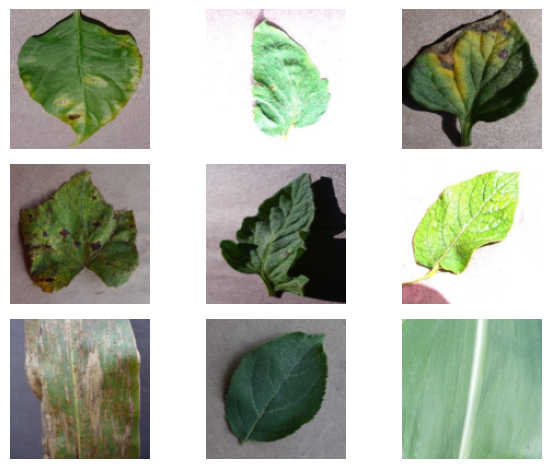

In [16]:
## displaying the samples from dataset 
n_rows =3  
n_cols =3 
f , axarr = plt.subplots(n_rows , n_cols) 

for row in range(n_rows): 
    for col in range(n_cols): 
        image = train_dataset[np.random.randint(0 ,  train_dataset.__len__())] 
        image = image[0].cpu() 
        axarr[row , col].imshow((image*255.0).squeeze().permute(1,2,0)) 
        axarr[row , col].axis('off')

plt.tight_layout() 
plt.show()
        


In [17]:
LR = 1e-3 
BATCH_SIZE = 4 
EPOCHS = 5 

In [18]:
from torch.utils.data import DataLoader 
train_dataloader = DataLoader(train_dataset , batch_size=BATCH_SIZE ,  shuffle=True) 
val_dataloader = DataLoader(val_dataset , batch_size=BATCH_SIZE , shuffle=True) 


In [19]:
from torchvision.models import googlenet
googlenet_model = googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 161MB/s] 


In [20]:
googlenet_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:
for param in googlenet_model.parameters(): 
    param.requires_grad = True 

In [22]:
num_classes = train_datasets['labels'].nunique()
num_classes

38

In [23]:
# this are the output features of the googlenet model
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [24]:
## replace above 1000 output features with our model features which are 38 classes only 
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features , num_classes) 
googlenet_model.fc

Linear(in_features=1024, out_features=38, bias=True)

In [28]:
## transfering the model to cuda 
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
from torch.optim import Adam
loss_fn = nn.CrossEntropyLoss() 
optimizer = Adam(googlenet_model.parameters() , lr = LR)

In [30]:
# we use to train model with  1.5×–2× speedup.
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_47/1856832024.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [32]:
## training loop 
total_train_loss_plot = [] 
total_train_acc_plot = []
print(f"Training started......")
googlenet_model.train()
for epoch in range(EPOCHS): 
    total_train_loss = 0
    total_train_acc = 0 

    for inputs,labels in train_dataloader: 
        # inputs = inputs.to(device , non_blocking=True) 
        # labels = labels.to(device , non_blocking=True) 
        
        optimizer.zero_grad() 
        outputs = googlenet_model(inputs) 
        train_loss = loss_fn(outputs ,  labels) 
        total_train_loss += train_loss.item() 

        train_loss.backward() 

        train_acc = (torch.argmax(outputs , axis=1) == labels).sum().item()
        total_train_acc += train_acc 
        optimizer.step() 

    total_train_loss_plot.append(round(total_train_loss/1000 , 4))
    total_train_acc_plot.append(round((total_train_acc/train_dataset.__len__())*100 , 4)) 
    print(
    f"Epoch {epoch+1}  || "
    f"train loss: {total_train_loss / len(train_dataloader)} || "
    f"train accuracy: {(total_train_acc / train_dataset.__len__()) * 100:.2f}%"
)

    
        


Training started......
Epoch 1  || train loss: 0.18189680135791694 || train accuracy: 94.03%
Epoch 2  || train loss: 0.1535202722176213 || train accuracy: 95.03%
Epoch 3  || train loss: 0.12849192470854418 || train accuracy: 95.74%
Epoch 4  || train loss: 0.11364706201867943 || train accuracy: 96.29%
Epoch 5  || train loss: 0.100403300010432 || train accuracy: 96.67%


In [33]:
with torch.no_grad(): 
    total_loss_test = 0 
    total_acc_test  = 0
    for inputs,labels in val_dataloader: 
        pred = googlenet_model(inputs) 
        acc = (torch.argmax(pred , axis=1)==labels).sum().item() 
        total_acc_test += acc 

        test_loss = loss_fn(pred , labels) 
        total_loss_test += test_loss.item() 

print(f"validation loss : {test_loss}") 
print(f"validation accuracy : {total_acc_test}")

validation loss : 0.0027272922452539206
validation accuracy : 16873


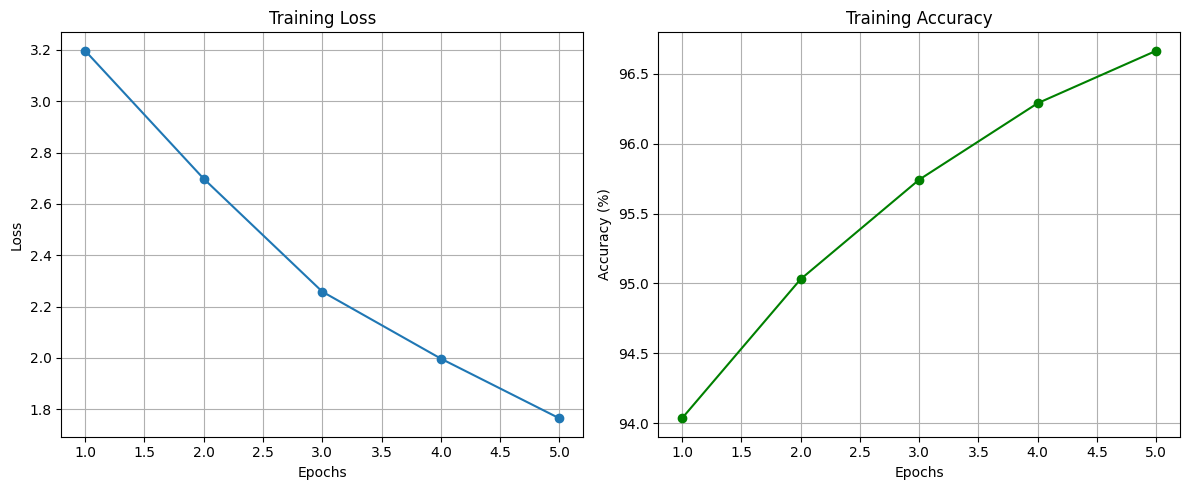

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(total_train_loss_plot) + 1)

plt.figure(figsize=(12, 5))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, total_train_loss_plot, marker='o')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, total_train_acc_plot, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [35]:
import torch

model_path = "googlenet_trained.pth"
torch.save(googlenet_model.state_dict(), model_path)

print(f"Model saved at {model_path}")


Model saved at googlenet_trained.pth


In [36]:
model = googlenet_model   # same architecture
model.load_state_dict(torch.load("googlenet_trained.pth", map_location=device))
model.eval()


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
pred = model(inputs)

In [39]:
for inputs , labels in train_dataloader: 
    # print(inputs , labels)
    pred = model(inputs) 
    acc = (torch.argmax(pred , axis=1)==labels).sum().item() 
    print(acc)
    break

4


In [41]:
train_dataset

(tensor([[[0.0014, 0.0014, 0.0013,  ..., 0.0021, 0.0021, 0.0021],
          [0.0014, 0.0013, 0.0014,  ..., 0.0021, 0.0021, 0.0021],
          [0.0013, 0.0013, 0.0014,  ..., 0.0021, 0.0021, 0.0021],
          ...,
          [0.0016, 0.0017, 0.0016,  ..., 0.0027, 0.0027, 0.0027],
          [0.0016, 0.0016, 0.0016,  ..., 0.0026, 0.0026, 0.0028],
          [0.0017, 0.0015, 0.0015,  ..., 0.0026, 0.0026, 0.0028]],
 
         [[0.0013, 0.0014, 0.0013,  ..., 0.0021, 0.0021, 0.0021],
          [0.0013, 0.0013, 0.0013,  ..., 0.0021, 0.0021, 0.0021],
          [0.0012, 0.0013, 0.0014,  ..., 0.0021, 0.0021, 0.0021],
          ...,
          [0.0016, 0.0017, 0.0017,  ..., 0.0028, 0.0027, 0.0028],
          [0.0016, 0.0016, 0.0016,  ..., 0.0027, 0.0027, 0.0028],
          [0.0018, 0.0016, 0.0015,  ..., 0.0026, 0.0027, 0.0028]],
 
         [[0.0016, 0.0016, 0.0016,  ..., 0.0025, 0.0025, 0.0025],
          [0.0016, 0.0016, 0.0016,  ..., 0.0025, 0.0025, 0.0025],
          [0.0015, 0.0016, 0.0017,  ...,

In [48]:
train_dataset.cla


AttributeError: 'CustomImageDataset' object has no attribute 'class_to_idx'

In [45]:
from PIL import Image
import torch
from torchvision import transforms

def predict_image(image_path):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((128,128)) , 
        transforms.ToTensor() 
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)   # add batch dimension
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        pred_class = torch.argmax(output, axis=1).item()

    return pred_class
pred = predict_image("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
label_classes[pred]

'Potato___healthy'

In [46]:
path = """/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___healthy/00907d8b-6ae6-4306-bfd7-d54471981a86___RS_HL 5709.JPG""" 
pred = predict_image(path)
label_classes[pred]

'Cherry_(including_sour)___healthy'